In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import seaborn as sns
import datetime

In [2]:
plt.style.use('default')

In [40]:
char = pd.read_csv('data/caracteristics.csv', low_memory=False,  encoding="latin-1")
users = pd.read_csv('data/users.csv', low_memory=False, encoding="latin-1")
places = pd.read_csv('data/places.csv', low_memory=False, encoding="latin-1")

### *characteristics.csv*

In [41]:
char.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839985 entries, 0 to 839984
Data columns (total 16 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Num_Acc  839985 non-null  int64  
 1   an       839985 non-null  int64  
 2   mois     839985 non-null  int64  
 3   jour     839985 non-null  int64  
 4   hrmn     839985 non-null  int64  
 5   lum      839985 non-null  int64  
 6   agg      839985 non-null  int64  
 7   int      839985 non-null  int64  
 8   atm      839930 non-null  float64
 9   col      839974 non-null  float64
 10  com      839983 non-null  float64
 11  adr      699443 non-null  object 
 12  gps      366226 non-null  object 
 13  lat      362471 non-null  float64
 14  long     362467 non-null  object 
 15  dep      839985 non-null  int64  
dtypes: float64(4), int64(9), object(3)
memory usage: 102.5+ MB


В char есть пробелы, согласно карте в описании датасетов, эти колонки отвечают географической локации, где произошла авария, поэтому, я считаю, что в данном случае некорректно дополнять пробелы самостоятельно. Впринципе, можно обойтись и без этих данных, просто исключив их из рассмотрения. Да, нельзя будет выявить самое опасное место во Франции по числу аварий, но, как мне кажется, это лучше чем обрезать половину датасета.

In [ ]:
char.drop(columns=['gps', 'lat', 'long', 'adr'], inplace=True)
char.drop_duplicates(inplace=True)

In [ ]:
char.shape

Дубликатов не было, судя по размеру. 
Посмотрим на остальные пропуски

In [ ]:
char.hist(column=['atm', 'col', 'com'], figsize=(18, 4), layout=(1, 3))

Осадки заполним по максимальному выпадению. Два других параметра, имеющих пропуски это код [INSEE](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%B4_INSEE) и тип столкновения. С типом столкновения, вроде понятно как быть, нужно посмотреть по id сколько объектов участвовало в аварии и уже исходя из этого сгенерировать пропущенное значение. Однако, так как число пропущенных значений составляет < 1% от всех данных, я думаю, проще будет просто убрать их из датасетов.

In [ ]:
char.atm.fillna(value=1, inplace=True) # Оно всего одно, я заполнил его самым частым

In [ ]:
index_com = char.Num_Acc[char.col.apply(np.isnan)]
index_col = char.Num_Acc[char.com.apply(np.isnan)]
index_to_del = list(index_com.index) + list(index_col.index)
index_num_acc = list(index_com) + list(index_col)

In [ ]:
char.drop(index=index_to_del, inplace=True)

In [ ]:
char.info()

Я сохранил индексы Num_Acc потому что их нужно также вывести из других датасетов

In [ ]:
def index_to_drop(df, values_to_check):
    '''Найдет все индексы в df, где элемент df будет равен values_to_check '''
    return [item for i in values_to_check for item in df[df == i].index]

In [ ]:
users.drop(index=index_to_drop(users.Num_Acc, index_num_acc), inplace=True)
places.drop(index=index_to_drop(places.Num_Acc, index_num_acc), inplace=True)

Проверим нулевые значения

In [ ]:
char.eq(0).any()

В двух колонках они есть, посмотрим сколько их

In [ ]:
char.int.eq(0).sum(), char.com.eq(0).sum()

В столбце *com* всего одно значение равно нулю, чего не должно быть, так как оно всего одно, просто заполним его медианным значением

In [ ]:
char.com.replace(to_replace=0, value=char.com.median, inplace=True)

Со столбцом *int* дело чуть хуже, потому что оно характеризует тип места, в котором произошла авария (тип перекрестка). Оно согласно описанию тоже не может быть нулем, чтобы понять как лучше восполнить пробелы посмотрим на гистограмму

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f81f0eba7c0>]],
      dtype=object)

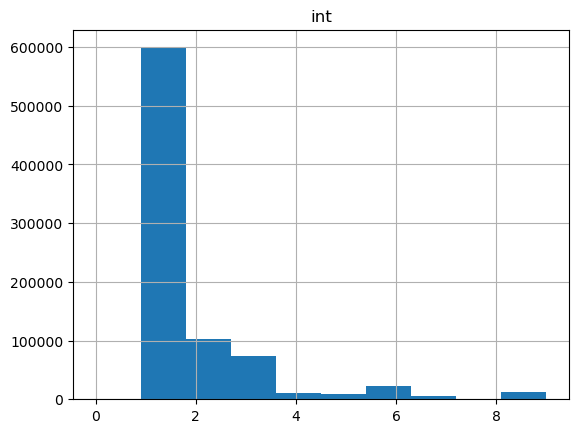

In [17]:
char.hist(column=['int'])

То есть подавляющее большинство столкновений произошло (1 - Out of intersection) вне разветвлений и поворотов, а просто на прямой?! Тут отличие в числах очень большое, наверное, не будет большой ошибкой, если заполнить нули этим значением.

In [18]:
char.int.replace(to_replace=0, value=1, inplace=True)

In [19]:
char.eq(0).any().sum()

0

In [20]:
char.head(2)

Num_Acc  an  mois  jour  hrmn  lum  agg  int  atm  col com  dep
0  201600000001  16     2     1  1445    1    2    1  8.0  3.0   5  590
1  201600000002  16     3    16  1800    1    2    6  1.0  6.0   5  590

Теперь попробуем погруппировать наши данные и посмотреть на распределения.

Посмотрим, например, на количество аварий по часам, тут опять же не совсем удобно записано время (с минутами), сделаем новую колонку где будут значения часа

In [21]:
char['hour'] = char['hrmn'].astype(str)

In [22]:
char.hour = char.hour.apply(lambda x: int(x.zfill(4)[:2]))

In [23]:
char.hour.unique()

array([14, 18, 19, 11, 10,  8, 16, 12,  7, 20, 15,  9,  5, 13, 17, 21,  3,
        6, 22,  2,  1,  4, 23,  0])

In [24]:
by_hours = char.groupby('hour')['Num_Acc'].count()

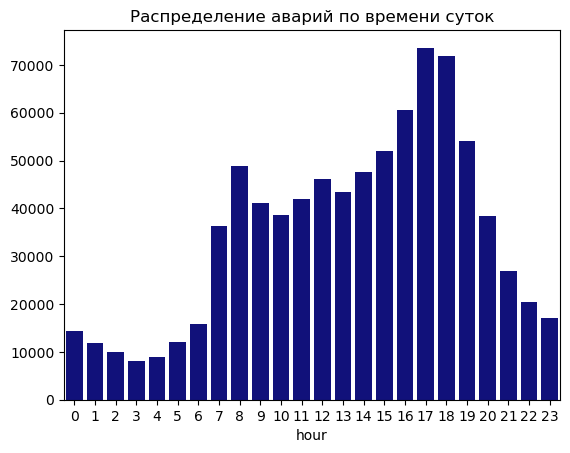

In [26]:
plt.title('Распределение аварий по времени суток')
sns.barplot(x=by_hours.index, y=by_hours.values, color='darkblue')

Видимо, большинство аварий случаются, вечером, когда люди возвращаются домой. 
Посмотрим еще на динамику аварий по годам и атмосферным условиям. Сначала по годам

In [27]:
# Переведем год в нормальный вид
char.an = char.an.apply(lambda x: x+2000)

In [28]:
year = char.groupby('an')['Num_Acc'].count()

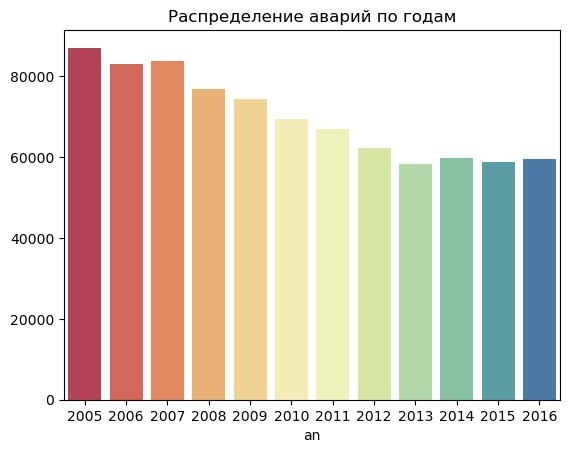

In [29]:
plt.title('Распределение аварий по годам')
sns.barplot(x=year.index, y=year.values, palette='Spectral')

Начиная с 2013 года, число аварий перестало уменьшаться и вышло на некоторое плато.
Попробуем построить более развернутую зависимость, посмотрим на число аварий в течении года по месяцам

In [30]:
char

Num_Acc    an  mois  jour  hrmn  lum  agg  int  atm  col  com  \
0       201600000001  2016     2     1  1445    1    2    1  8.0  3.0    5   
1       201600000002  2016     3    16  1800    1    2    6  1.0  6.0    5   
2       201600000003  2016     7    13  1900    1    1    1  1.0  6.0   11   
3       201600000004  2016     8    15  1930    2    2    1  7.0  3.0  477   
4       201600000005  2016    12    23  1100    1    2    3  1.0  3.0   11   
...              ...   ...   ...   ...   ...  ...  ...  ...  ...  ...  ...   
839980  200500087950  2005    12    21  2035    5    2    2  1.0  3.0  416   
839981  200500087951  2005    12    23  1010    1    2    1  1.0  3.0  416   
839982  200500087952  2005    12    26  1715    1    2    2  1.0  3.0  416   
839983  200500087953  2005    12    27  1500    1    2    3  2.0  5.0  416   
839984  200500087954  2005    12    31  2100    5    2    1  2.0  7.0  414   

        dep  hour  
0       590    14  
1       590    18  
2       590    19  
3       590    19  
4       590    11  
...     ...   ...  
839980  974    20  
839981  974    10  
839982  974    17  
839983  974    15  
839984  974    21  

[839972 rows x 13 columns]

Сгруппируем по годам, месяцам и дням. Затем сделаем одну колонку с датой события вместо трёх

In [35]:
time_scale = char.groupby(by=['an', 'mois', 'jour'])["Num_Acc"].count()
index = time_scale.index

# # time_scale['date'] = [datetime.date(*index) for index in time_scale.index]
time_scale = time_scale.reset_index()

In [36]:
time_scale['date'] = [datetime.date(*i) for i in index]

In [37]:
time_scale['day_number'] = time_scale.date.apply(lambda x: x.timetuple().tm_yday)

In [38]:
time_scale

an  mois  jour  Num_Acc        date  day_number
0     2005     1     1      180  2005-01-01           1
1     2005     1     2      137  2005-01-02           2
2     2005     1     3      234  2005-01-03           3
3     2005     1     4      279  2005-01-04           4
4     2005     1     5      270  2005-01-05           5
...    ...   ...   ...      ...         ...         ...
4378  2016    12    27      144  2016-12-27         362
4379  2016    12    28      139  2016-12-28         363
4380  2016    12    29      110  2016-12-29         364
4381  2016    12    30      125  2016-12-30         365
4382  2016    12    31       92  2016-12-31         366

[4383 rows x 6 columns]

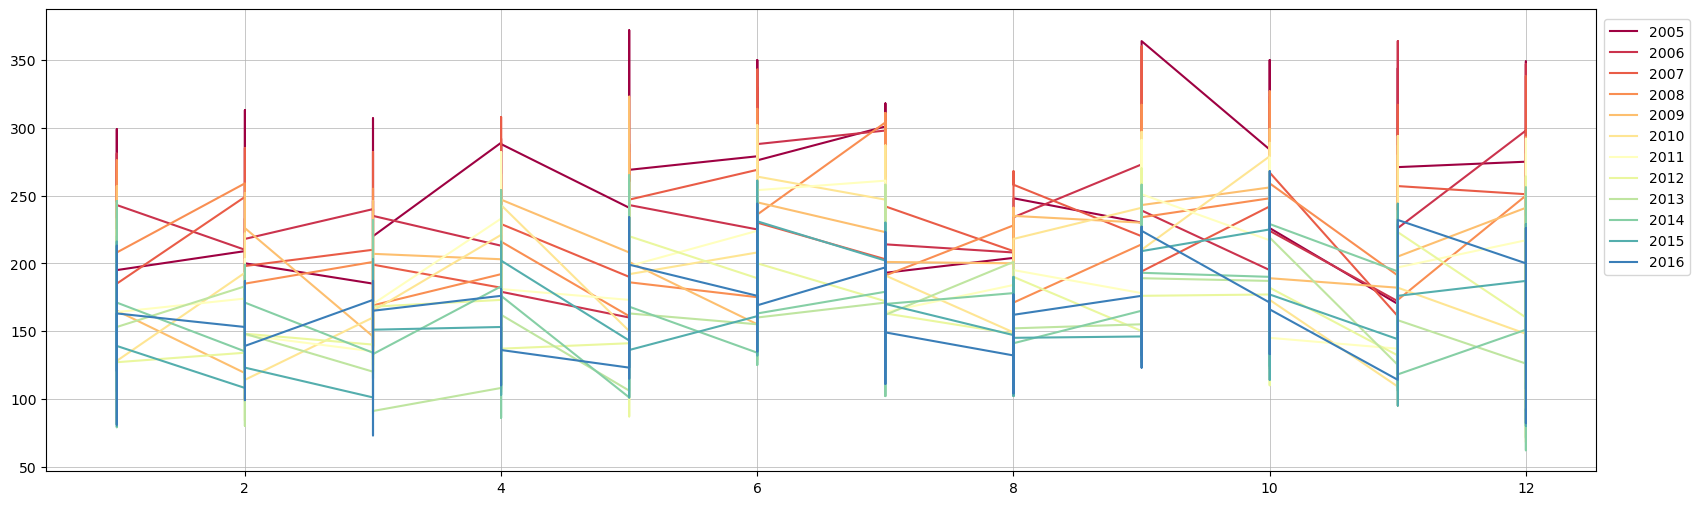

In [39]:
plt.figure(figsize=(20, 6))
plt.grid('--', lw=0.5, )

cm = plt.get_cmap('Spectral')
unique_year = time_scale.an.unique()

for num, year in enumerate(unique_year):
    plt.plot(time_scale.loc[time_scale.an == year, 'mois'], time_scale.loc[time_scale.an == year, 'Num_Acc'], 
             label=year,
             color=cm(num / len(unique_year))
            )
# _ = plt.xticks(range(len(all_days_in_year)), labels=all_days_in_year)
plt.legend(loc=(1.005, 0.425))

In [165]:
datetime.datetime.strptime('1 2', '%M %d')

datetime.datetime(1900, 1, 2, 0, 1)